In [2]:
import tabula
import numpy as np
import pandas as pd
import seaborn as sb

# read in pdf
df1 = tabula.read_pdf('data/Kontoauszug_1032515684_Nr_2019_001_per_2019_01_04.pdf')
df2 = tabula.read_pdf('data/Kontoauszug_1032515684_Nr_2018_005_per_2018_04_30.pdf')
df  = [df1, df2]
df  = pd.concat(df, ignore_index = True)

# inspect table
#print(df.columns)
#print(df.shape)
#print(df)

# rename columns
df.columns = ["date", "value", "subject", "minus", "plus"]
#print(df)

# get NA columns
na_index  = (df["date"].isna().index[df["date"].isna() == False].tolist())
na_index.extend([df.shape[0]])

# concatenate subjects which actually belong together
s = " "
for i in range(0, len(na_index) - 1):
    df.iloc[na_index[i], 2] = s.join(df.iloc[range(na_index[i], na_index[i+1]), 2])

# remove rows with NA
df = df[pd.notnull(df['date'])]
#print(df)

# adding categories
df.index = range(0, df.shape[0], 1)
df['category'] = pd.Series(['car', 'mobile', 'car', 'shopping', 'groceries', 'shopping', 'loan', 'other', 'rent', 
                           'groceries', 'groceries', 'shopping', 'credit card', 'canteene', 'holiday', 'shopping',
                           'travel', 'mobile'], 
                             index = df.index)

# replace NULL with 0
df = df.fillna('0,0')

# convert to numerics
for i in range(0, df.shape[0]):
    df.iloc[i, 3] = float(df.iloc[i, 3].replace(',', '.'))
    df.iloc[i, 4] = float(df.iloc[i, 4].replace(',', '.'))
#print(df)

# cluster expenses
df_exp = df[['category', 'minus']]
df_exp = df_exp.groupby(['category']).sum().reset_index()
df_exp = df_exp.drop(df_exp[df_exp.minus == 0].index)
#print(df_exp)

# cluster income
df_inc = df[['category', 'plus']]
df_inc = df_inc.groupby(['category']).sum().reset_index()
df_inc = df_inc.drop(df_inc[df_inc.plus == 0].index)
#print(df_inc)

# cluster all
df_all = df[['category', 'minus', 'plus']]
df_all = df_all.groupby(['category']).sum().reset_index()

# sort by largest categories
df_all = df_all.sort_values(by = ['minus', 'plus'], ascending = False)

print(df_all)

      date   value                                            subject   minus  \
0   02.01.  02.01.  Kartenzahlung ARAL AG SVWZ+2018-12-29T00.48 De...   50,20   
4   02.01.  02.01.  Basislastschrift E-Plus Service GmbH EREF+3384...   15,00   
10  02.01.  02.01.  Kartenzahlung ARAL AG SVWZ+2018-12-28T19.36 De...   61,53   
15  02.01.  02.01.  Basislastschrift AMAZON PAYMENTS EUROPE S.C. A...   21,98   
21  02.01.  02.01.  Kartenzahlung NAHKAUF FRISCHEMARKT SVWZ+2018-1...   18,98   
25  02.01.  02.01.  Basislastschrift AMAZON PAYMENTS EUROPE S.C. A...   80,48   
31  02.01.  02.01.  Basislastschrift Bundeskasse in Halle EREF+552...  315,00   
36  02.01.  02.01.    Zahlungseingang BENJAMIN KAMMERECK SVWZ+MSC JGA     NaN   
39  02.01.  02.01.                     Zahlungseingang Helmut Matejka     NaN   
41  05.04.  05.04.  Basislastschrift HIT EREF+IC-7335128958 MREF+6...   17,49   
46  09.04.  09.04.  Kartenzahlung NAHKAUF FRISCHEMARKT SVWZ+2018-0...   15,02   
50  09.04.  09.04.  Überweis

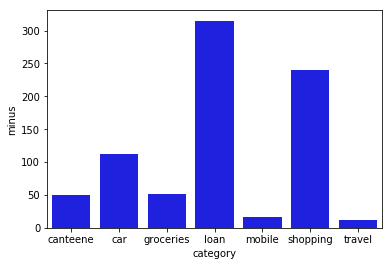

In [57]:
# barplot seaborn
sb.barplot(x = "category", y = "minus", data = df_exp, label = "Total", color = "b")
#sb.barplot(x = "category", y = "plus", data = df_inc, label = "Total", color = "b")

In [58]:
# Bokeh libraries
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel

# Determine where the visualization will be rendered
#output_file('filename.html')  # Render to static HTML, or 
output_notebook()  # Render inline in a Jupyter Notebook

# Create a ColumnDataSource object
expenses = ColumnDataSource(df_all)

# Create a figure with a datetime type x-axis
fig = figure(x_range = df_all['category'], title = 'Bank Account Movements by Category',
             x_axis_label = 'category', y_axis_label = 'amount [€]',
             toolbar_location = None )

# The expenses will be represented as vertical bars (columns)
fig.vbar(x = 'category', top = 'minus', source = expenses,
         color = 'coral', width = 0.75, 
         legend = 'Expenses')

# income as well
fig.vbar(x = 'category', top = 'plus', source = expenses,
         color = 'limegreen', width = 0.75, 
         legend = 'Income')

# Put the legend in the upper left corner
fig.legend.location = 'top_right'

# Let's check it out
show(fig)

Loading BokehJS ...

In [59]:
for i in range(0, df.shape[0]):
    if df.iloc[i, 2].find("ARAL") != -1:
        print("car")
    elif df.iloc[i, 2].find("AMAZON") != -1:
        print("shopping")
    elif df.iloc[i, 2].find("E-Plus") != -1:
        print("mobile")
    elif df.iloc[i, 2].find("FRISCHEMARKT") != -1:
        print("groceries")
    elif df.iloc[i, 2].find("Bundeskasse in Halle") != -1:
        print("student loan")
    elif df.iloc[i, 2].find("Matejka") != -1:
        print("rent simbach")
    elif df.iloc[i, 2].find("KREDITKARTENABRECHNUNG") != -1:
        print("credit card")
    elif df.iloc[i, 2].find("HIT") != -1:
        print("groceries")
    else:
        print("other")
        print(df.iloc[i, 2])

car
mobile
car
shopping
groceries
shopping
student loan
other
Zahlungseingang BENJAMIN KAMMERECK SVWZ+MSC JGA
rent simbach
groceries
groceries
other
Überweisung STRATIC LEDERWAREN JACOB BO KREF+HKCCS57577 SVWZ+0521.7646.3058 1000162 71152 3284646 DATUM 09.04.2018, 16.39 UHR 1.TAN 194692
credit card
other
Kartenzahlung ALLIANZ AG MUEN. SVWZ+2018-04-04T08.38.43 Ka rte0 2018-12 ABWA+ALLIANZ//MUENCHEN/DE
other
Zahlungseingang Killy Wu SVWZ+Highschool Girl thanks handsome Surfi Boi for a g reat time down under OO
shopping
other
Kartenzahlung DB Vertrieb GmbH SVWZ+2018-04-17T09.04.37 Ka rte0 2018-12 ABWA+DB AUTOMAT//MUENCHEN M ARIENPLATZ/DE
other
Basislastschrift
